In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import info_map
from scripts.arena import Arena, Aperture, Mouse, visualize_arena
from tqdm import tqdm
import os

In [2]:
arena = Arena(length=60, width=60, height=50)
aperture = Aperture(arena_width=60, arena_height=50, arena_length=60, gap_width=10)
circleL = (arena.width/2 - aperture.gap_width, arena.width, arena.height/2)
circleR = (arena.width/2 + aperture.gap_width, arena.width, arena.height/2)



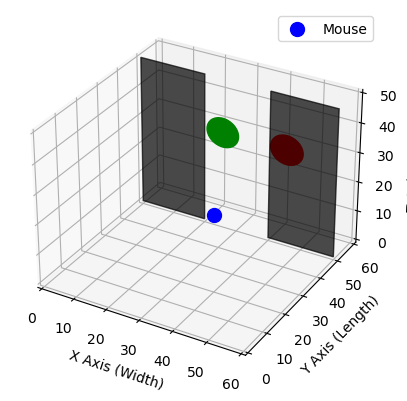

In [3]:
mouse = Mouse(40, 20, 25)
visualize_arena(arena, mouse, aperture)

In [4]:
def get_visibility(source, target, aperture):
    v_t2Lwall = np.subtract(aperture.left_wall_edge + (target[2],), target)
    v_t2Lwall = v_t2Lwall/np.linalg.norm(v_t2Lwall)
    v_t2Rwall = np.subtract(aperture.right_wall_edge + (target[2],), target)
    v_t2Rwall = v_t2Rwall/np.linalg.norm(v_t2Rwall)

    # Vector from target to source (normalized)
    v_t2s = np.subtract(source, target)
    v_t2s = v_t2s / np.linalg.norm(v_t2s)

    # Cross products to determine the relative position of v_target2source
    cross_LS = np.cross(v_t2Lwall[:2], v_t2s[:2])
    cross_RS = np.cross( v_t2s[:2], v_t2Rwall[:2],)
    # Check if v_target2source is between the left and right wall vectors

    if cross_LS >=0 and cross_RS >=0:
        return True
    else:
        return False


def get_visible_angles(source, circle_center, radius, aperture):
    """
    Calculate the visible area of a circle from a given point by checking the visibility
    of various points on the circle's perimeter.
    """
    d_theta = np.pi/180  # Increase for higher accuracy
    angles = np.arange(0, 2 * np.pi, d_theta)
    visible_angles = []
    
    for i in range(len(angles)-1):
        # Parametrize the circle
        x_circle = circle_center[0] + radius * np.cos(angles[i])
        z_circle = circle_center[2] + radius * np.sin(angles[i])
        y_circle = circle_center[1]  # Y remains the same for a circle in the YZ plane
        
        circle_point = (x_circle, y_circle, z_circle)
        flag = get_visibility(source, circle_point, aperture)
        if flag:
            visible_angles.append(angles[i])
    #print(len(angles), len(visible_angles))
    #area  = get_segment_area(visible_angles, radius)
    return visible_angles

def get_segment_area(angles, radius):
    if len(angles)==0:
        return (0, 0)
    else:
        # Sort the angles
        angles = np.sort(angles)
        # Calculate the differences between consecutive angles
        if (0 in angles):
            diffs = np.diff(angles, append=angles[-1]-angles[0])# + 2 * np.pi - angles[-1])
        else:
            diffs = np.abs(np.diff(angles, append=angles[0]))
        # Find the largest gap, which is the central angle of the segment
        central_angle = np.max([np.max(diffs), np.min(diffs)])
        #print(central_angle)
        # Calculate the area of the circular segment
        # Area of segment = 0.5 * radius^2 * (theta - sin(theta))
        area = 0.5 * radius**2 * (central_angle - np.sin(central_angle))

        # area compliment 
        area_c = np.abs(np.pi*radius**2 - area)
        return np.array([area, area_c])

def infoMetric(area1, area2):
    return 0.5 * np.abs(area1 + area2)

def info_map(arena, circle1_center, circle2_center, aperture, radius):
    x_resolution = arena.width
    y_resolution = arena.length - aperture.gap_width

    x = np.linspace(0, arena.length, x_resolution)
    y = np.linspace(0, arena.width, y_resolution)

    info_mat = np.zeros((x_resolution, y_resolution))
    print(info_mat.shape, '\n')
    # Iterate through a grid of points in the arena
    for i in tqdm(range(x_resolution)):
        for j in range(y_resolution):
            source = (x[i], y[j], 20)
            visible_anglesL = get_visible_angles(source, circle1_center, radius, aperture)
            visible_anglesR = get_visible_angles(source, circle2_center, radius, aperture)

            area_circle1 = get_segment_area(visible_anglesL, radius)
            area_circle2 = get_segment_area(visible_anglesR, radius)

            # Check whether to use major or minor segment area

            # larger element of area_circle is last element
            if source[0] > arena.length/2:
                A1 = np.max(area_circle1)
                A2 = np.min(area_circle2)
            elif source[0] < arena.length/2:
                A1 = np.min(area_circle1)
                A2 = np.max(area_circle2)
            else: 
                A1 = area_circle1[0]
                A2 = area_circle2[0]    

            info_mat[i, j] = infoMetric(A1, A2) 
    return info_mat

In [5]:
circleR

(40.0, 60, 25.0)

In [6]:
source = (10, 0, 20)
target = (40, 60, 25)
x=get_visible_angles(source, circleL, 5, aperture)
v = get_visibility(source, target, aperture)
print(x)
a =get_segment_area(x, 5)
print(a[1])


NameError: name 'get_visible_area' is not defined

In [7]:
info_mat = info_map(arena, circleL, circleR, aperture, radius=5)


(60, 50) 



100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


In [6]:
BASE_PATH = "/Users/reecekeller/Documents/Xaq/act_sense/act_sense/data/"


In [8]:
np.save(os.path.join(BASE_PATH, 'info_matrix.npy'), info_mat)

In [7]:
info_map = np.load(BASE_PATH + 'info_matrix.npy')

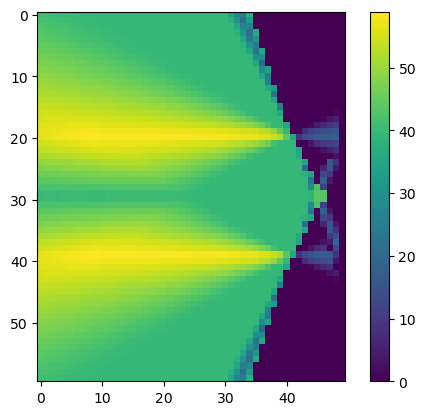

In [17]:
plt.imshow(info_map)
plt.colorbar()
plt.show()


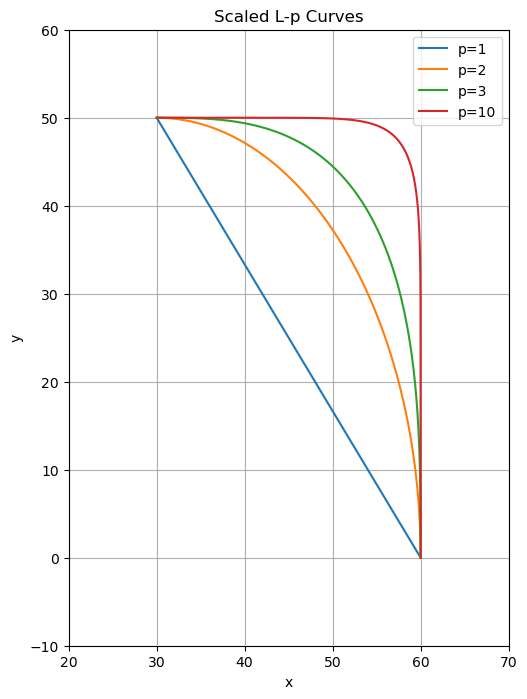

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L-p norm curve in the first quadrant
def lp_curve_scaled(p, num_points=1000, start=(30, 0), end=(60, 50)):
    # Generate angles for the first quadrant (0 to pi/2)
    theta = np.linspace(0, np.pi / 2, num_points)
    
    # Parametrize x and y using the Lp norm equation (r=1, for simplicity)
    x = np.cos(theta)
    y = np.sin(theta)
    
    # Transform to Lp norm by raising to power of p and normalizing
    x_lp = np.sign(x) * (np.abs(x) ** (2 / p))
    y_lp = np.sign(y) * (np.abs(y) ** (2 / p))
    
    # Normalize to satisfy the equation |x|^p + |y|^p = 1^p
    norm_factor = (np.abs(x_lp) ** p + np.abs(y_lp) ** p) ** (1 / p)
    x_lp /= norm_factor
    y_lp /= norm_factor
    
    # Scale to the target size
    start_x, start_y = start
    end_x, end_y = end
    
    # Compute scaling factors
    scale_x = end_x - start_x
    scale_y = end_y - start_y
    
    # Scale the points
    x_scaled = x_lp * scale_x + start_x
    y_scaled = y_lp * scale_y + start_y
    
    return x_scaled, y_scaled

# Plot Lp curves for different p with start at (30, 0) and end at (60, 50)
def plot_lp_curves_scaled(p_values, start=(30, 0), end=(60, 50)):
    plt.figure(figsize=(8, 8))
    
    for p in p_values:
        x_scaled, y_scaled = lp_curve_scaled(p, start=start, end=end)
        plt.plot(x_scaled, y_scaled, label=f'p={p}')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Scaled L-p Curves')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(20, 70)  # Adjust x limits to give space for the curves
    plt.ylim(-10, 60)  # Adjust y limits to include the full curve
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
p_values = [1, 2, 3, 10]  # Different p values for L-p norms

# Plot the L-p curves starting at (30, 0) and ending at (60, 50)
plot_lp_curves_scaled(p_values, start=(30, 0), end=(60, 50))


In [26]:
data

{1: [array([60.        , 59.99992583, 59.99970332, 59.99933247, 59.99881329,
         59.99814578, 59.99732995, 59.9963658 , 59.99525335, 59.99399261,
         59.99258358, 59.99102629, 59.98932074, 59.98746697, 59.98546497,
         59.98331478, 59.98101641, 59.97856989, 59.97597524, 59.97323249,
         59.97034166, 59.96730278, 59.96411589, 59.96078101, 59.95729818,
         59.95366743, 59.9498888 , 59.94596233, 59.94188805, 59.937666  ,
         59.93329623, 59.92877877, 59.92411369, 59.91930101, 59.91434079,
         59.90923307, 59.90397791, 59.89857537, 59.89302548, 59.88732831,
         59.88148392, 59.87549236, 59.86935368, 59.86306796, 59.85663526,
         59.85005563, 59.84332914, 59.83645586, 59.82943586, 59.8222692 ,
         59.81495597, 59.80749622, 59.79989003, 59.79213749, 59.78423866,
         59.77619362, 59.76800245, 59.75966524, 59.75118206, 59.74255301,
         59.73377816, 59.7248576 , 59.71579143, 59.70657972, 59.69722257,
         59.68772008, 59.67807234, 

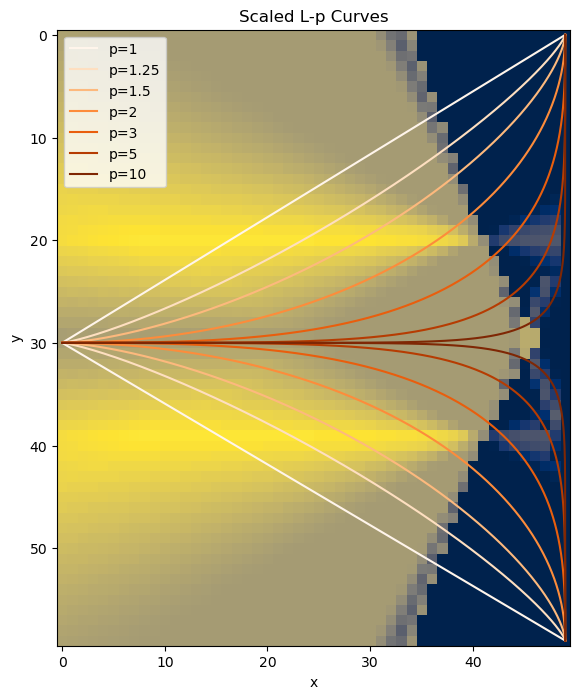

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L-p norm curve in the first quadrant
def lp_curve_scaled(p, num_points=1000, start=(30, 0), end=(60, 50)):
    # Generate angles for the first quadrant (0 to pi/2)
    theta = np.linspace(0, np.pi / 2, num_points)
    
    # Parametrize x and y using the Lp norm equation (r=1, for simplicity)
    x = np.cos(theta)
    y = np.sin(theta)
    
    # Transform to Lp norm by raising to power of p and normalizing
    x_lp = np.sign(x) * (np.abs(x) ** (2 / p))
    y_lp = np.sign(y) * (np.abs(y) ** (2 / p))
    
    # Normalize to satisfy the equation |x|^p + |y|^p = 1^p
    norm_factor = (np.abs(x_lp) ** p + np.abs(y_lp) ** p) ** (1 / p)
    x_lp /= norm_factor
    y_lp /= norm_factor
    
    # Scale to the target size
    start_x, start_y = start[0], end[1]
    end_x, end_y = end[0], start[1]
    
    # Compute scaling factors
    scale_x = end_x - start_x
    scale_y = end_y - start_y
    
    # Scale the points
    x_scaled = x_lp * scale_x + start_x
    y_scaled = y_lp * scale_y + start_y
    
    return x_scaled, y_scaled

# Plot Lp curves for different p with start at (30, 0) and end at (60, 50)
def plot_lp_curves_scaled(p_values, start=(30, 0), end1=(60, 50), end2 = (60, 50)):
    plt.figure(figsize=(8, 8))
    plt.imshow(info_map, cmap = 'cividis')
    colors = plt.cm.Oranges(np.linspace(0, 1, len(p_values)))  # You can choose other colormaps

    for i, p in enumerate(p_values):
        color = colors[i]
        x_scaled1, y_scaled1 = lp_curve_scaled(p, start=start, end=end1)
        x_scaled2, y_scaled2 = lp_curve_scaled(p, start=start, end=end2)
        plt.plot(x_scaled1, y_scaled1, color=color, label=f'p={p}')        
        plt.plot(x_scaled2, y_scaled2, color=color)

    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Scaled L-p Curves')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.legend()
    plt.show()

# Parameters
p_values = [1, 1.25, 1.5, 2, 3, 5, 10]  # Different p values for L-p norms

# Plot the L-p curves starting at (30, 0) and ending at (60, 50)
plot_lp_curves_scaled(p_values, start=(0, 30), end1=(49, 0), end2=(49, 59))



In [ ]:
x = np.array([120, 130, 180, 200])
np.abs(np.diff(x, append=x[0]))
x = np.array([0, 10, 50, 100, 150, 220, 260, 300, 350, 359])
np.diff(x, append=x[-1]-x[0])

array([10, 40, 50, 50, 70, 40, 40, 50,  9,  0])

In [ ]:
x = np.array([0, 10, 20, 25, 35, 340, 350, 355])
np.diff(x, append=x[-1]-x[0])
x = np.array([70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 270, 290])
np.abs(np.diff(x, append=x[0]))


array([  10,   10,   10,   20,   20,   20,   20,   20,   20,   20,   20,
         10,   20, -220])

In [ ]:
source = (20, 20, 25)
target = (45, 60, 25)

flag = get_visibility(source, target, aperture)
a_L=get_visible_angles(source, circleL, 5, aperture)
a_R=get_visible_angles(source, circleR, 5, aperture)

# confirmed: less points in a_R than a_L for this source and target
area_circle1 = get_segment_area(a_L, 5)
area_circle2 = get_segment_area(a_R, 5)
d_theta = np.pi/180  # Increase for higher accuracy
angles = np.arange(0, 2 * np.pi, d_theta)

if source[0] > arena.length/2:
    A1 = np.max(area_circle1)
    A2 = np.min(area_circle2)
elif source[0] < arena.length/2:
    A1 = np.min(area_circle1)
    A2 = np.max(area_circle2)
else: 
    A1 = area_circle1[0]
    A2 = area_circle2[0]    
print(len(a_L), len(a_R))
print(area_circle1, area_circle2)
print(A1, A2, 0.5*(A1+A2))


180 359
[39.26990817 39.26990817] [1.10760332e-05 7.85398053e+01]
39.269908169872416 78.53980526371159 58.904856716792


In [ ]:
0 in a_L

True

In [ ]:
source = (40, 20, 25)
#target = (45, 60, 25)

flag = get_visibility(source, target, aperture)
a_L=get_visible_angles(source, circleL, 5, aperture)
a_R=get_visible_angles(source, circleR, 5, aperture)

# confirmed: less points in a_R than a_L for this source and target
area_circle1 = get_segment_area(a_L, 5)
area_circle2 = get_segment_area(a_R, 5)
d_theta = np.pi/180  # Increase for higher accuracy
angles = np.arange(0, 2 * np.pi, d_theta)

if source[0] > arena.length/2:
    A1 = np.max(area_circle1)
    A2 = np.min(area_circle2)
elif source[0] < arena.length/2:
    A1 = np.min(area_circle1)
    A2 = np.max(area_circle2)
else: 
    A1 = area_circle1[0]
    A2 = area_circle2[0]    
print(len(a_L), len(a_R))
print(area_circle1, area_circle2)
print(A1, A2, 0.5*(A1+A2))


359 181
[1.10760332e-05 7.85398053e+01] [39.26990817 39.26990817]
78.53980526371159 39.269908169872416 58.904856716792


In [ ]:
np.pi*5**2

78.53981633974483

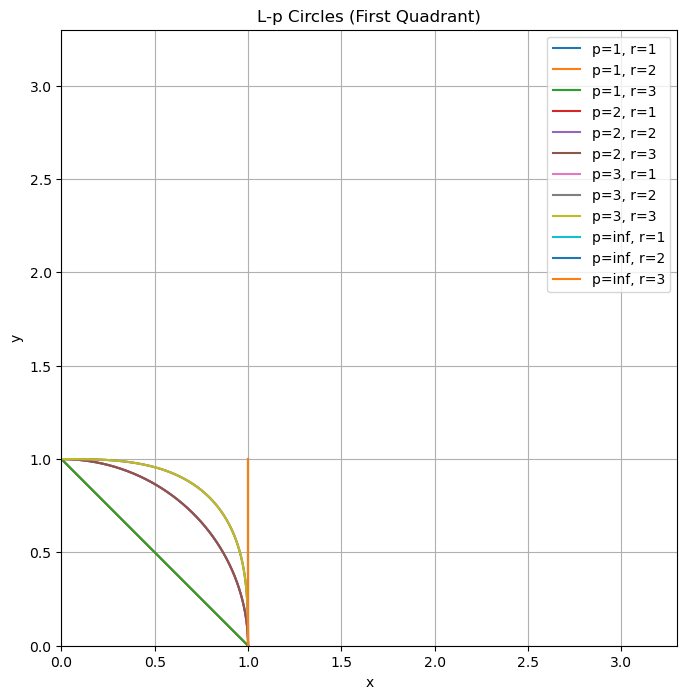

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L-p norm circle in the first quadrant
def lp_circle_first_quadrant(p, r, num_points=1000):
    # Generate angles for the first quadrant (0 to pi/2)
    theta = np.linspace(0, np.pi / 2, num_points)
    
    # Parametrize x and y using the Lp norm equation
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Transform to Lp norm by raising to power of p and normalizing
    x_lp = np.sign(x) * (np.abs(x) ** (2 / p))
    y_lp = np.sign(y) * (np.abs(y) ** (2 / p))
    
    # Normalize to satisfy the equation |x|^p + |y|^p = r^p
    norm_factor = (np.abs(x_lp) ** p + np.abs(y_lp) ** p) ** (1 / p)
    x_lp /= norm_factor
    y_lp /= norm_factor
    
    return x_lp, y_lp

# Plot Lp circles for different p and radii in the first quadrant
def plot_lp_circles_first_quadrant(radii, p_values):
    plt.figure(figsize=(8, 8))
    
    for p in p_values:
        for r in radii:
            x_lp, y_lp = lp_circle_first_quadrant(p, r)
            plt.plot(x_lp, y_lp, label=f'p={p}, r={r}')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('L-p Circles (First Quadrant)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, max(radii) * 1.1)  # Extend x-axis slightly for better visualization
    plt.ylim(0, max(radii) * 1.1)  # Extend y-axis slightly for better visualization
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
radii = [1, 2, 3]  # Different radii to plot
p_values = [1, 2, 3, np.inf]  # Different p values for L-p norms

# Plot the L-p circles in the first quadrant
plot_lp_circles_first_quadrant(radii, p_values)
